In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# VAE Tutorial 

![](https://lilianweng.github.io/posts/2018-08-12-vae/vae-gaussian.png)

An **AutoEncoder** learns an identity mapping through two neural networks: $(i)$ **Encoder** and $(ii)$ **Decoder**. Encoder learns to map each input data to a fixed latent representation and Decoder learns to reconstruct the input data from fixed latent representation. 


Different from AutoEncoder models, **[Variational Autoencoder](https://arxiv.org/abs/1312.6114)** uses Variational Bayes.


**Encoder** network learns to map each input data into a distribution, instead of a fixed latent representation. **Decoder** network learns to reconstruct the input data from the latent distribution. Once the training is complete, we can simply use the **Decoder** network as a standalone to generate new data, i.e., synthetic data. While **AutoEncoder** share quite similar architecture like a **Variational Autoencoder (VAE)**, we can't use the Decoder network of AutoEncoder to generate synthetic data, as it does not learn to map the input-data into a latent distribution, instead it learns to map into a fixed code.



The parameters of Encoder and Decoder network $(\phi, \theta)$ are optimized jointly. We use the following loss function to optimize the parameters of VAE.


\begin{aligned}
    L_\text{VAE}(\theta, \phi) 
    &= -\log p_\theta(\mathbf{x}) + D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}\vert\mathbf{x}) )\\
    &= - \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z}\vert\mathbf{x})} \log p_\theta(\mathbf{x}\vert\mathbf{z}) + D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}) ) \\
    \theta^{*}, \phi^{*} &= \arg\min_{\theta, \phi} L_\text{VAE}
\end{aligned}

### Further Reading
- **[From Autoencoder to Beta-VAE](https://lilianweng.github.io/posts/2018-08-12-vae/)**
- **Variational Inference [1](https://www.cse.iitk.ac.in/users/piyush/courses/pml_autumn22/slides/CS772-Lec13.pdf), [2](https://www.cse.iitk.ac.in/users/piyush/courses/pml_autumn22/slides/CS772-Lec14.pdf), [3](https://www.cse.iitk.ac.in/users/piyush/courses/pml_autumn22/slides/CS772-Lec15.pdf)**
- **[Deep Generative Models](https://www.cse.iitk.ac.in/users/piyush/courses/pml_autumn22/slides/CS772-Lec22.pdf)**

### Define Transformation

In [2]:
train_transform = transforms.Compose([transforms.RandomResizedCrop(32), transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

test_transform = transforms.Compose([transforms.Resize(32), 
                                     transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

### Load train and test data

In [3]:
train_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=train_transform)

test_dataset = datasets.FashionMNIST(root='../data', train=False, download=True, transform=test_transform)

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, 
                                           shuffle=True, num_workers=4, 
                                           pin_memory=True)



test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True,
                                          num_workers=4, pin_memory=True)

In [5]:
train_batch, _ = next(iter(train_loader))

test_batch, _ = next(iter(test_loader))

In [6]:
train_grid_img = torchvision.utils.make_grid(train_batch, nrow=8)

test_grid_img = torchvision.utils.make_grid(test_batch, nrow=8)

#### Display a batch of training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


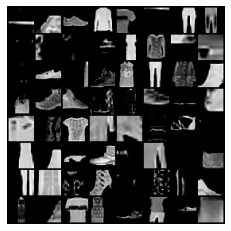

In [7]:
plt.imshow(train_grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

#### Display a batch of test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


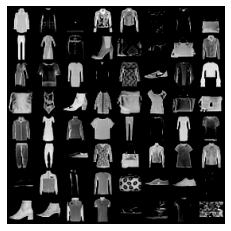

In [8]:
plt.imshow(test_grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [9]:
!python --version

Python 3.7.7


## Define Variational Autoencoder (VAE)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


class VAE(nn.Module):
    
    def __init__(self, z_dim=32, nc=3):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.nc = nc
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 16, 4, 2, 1, bias=False),              
            nn.BatchNorm2d(16),
            nn.LeakyReLU(True),
            nn.Conv2d(16, 16, 4, 2, 1, bias=False),             
            nn.BatchNorm2d(16),
            nn.LeakyReLU(True),
            nn.Conv2d(16, 32, 4, 2, 1, bias=False),             
            nn.BatchNorm2d(32),
            nn.LeakyReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),            
            nn.BatchNorm2d(64),
            nn.LeakyReLU(True),
            View((-1, 64*2*2)),                                 
        )

        self.fc_mu = nn.Linear(64*2*2, z_dim)                   
        self.fc_logvar = nn.Linear(64*2*2, z_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 64*4*4),                           
            View((-1, 64, 4, 4)),                               
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),   
            nn.BatchNorm2d(32),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1, bias=False),    
            nn.BatchNorm2d(32),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),    
            nn.BatchNorm2d(16),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(16, nc, 1),                       
            nn.Tanh()
        )
        
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            try:
                for m in self._modules[block]:
                    kaiming_init(m)
            except:
                kaiming_init(block)
                
    

    def forward(self, x):
        z = self._encode(x)
        
        mu, logvar = self.fc_mu(z), self.fc_logvar(z)
        
        z = self.reparameterize(mu, logvar)
        
        x_recon = self._decode(z)

        return x_recon, z, mu, logvar

    def reparameterize(self, mu, logvar):
        stds = torch.exp(0.5 * logvar)
        
        epsilon = torch.randn_like(logvar)

        stds, epsilon = stds.to(mu.device), epsilon.to(mu.device)

        latents = epsilon * stds + mu
        return latents

    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)
    
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

In [11]:
model = VAE(nc=1)
print(model)



VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): View()
  )
  (fc_mu): Linear(in_features=256, out_features=32, bias=True)
  (fc_logvar): Linear

In [12]:
class VAELoss(nn.Module):
    
    def __init__(self):
        super(VAELoss, self).__init__()
        
        self.mse_loss = nn.MSELoss(reduction='sum')
        
    def forward(self, x, recon, mu, logvar, beta=1.0):
        MSE = self.mse_loss(recon, x)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        KLD = KLD * beta
        return MSE + KLD



In [13]:
data = torch.randn(10, 1, 32, 32)

with torch.no_grad():
    x_recon, z, mu, logvar = model(data)
    
print(data.size())
print(x_recon.size(), z.size(), mu.size(), logvar.size())

torch.Size([10, 1, 32, 32])
torch.Size([10, 1, 32, 32]) torch.Size([10, 32]) torch.Size([10, 32]) torch.Size([10, 32])


### Training

In [14]:
# loss function
criterion = VAELoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
n_epochs = 30

model.train()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model.to(device)

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for i, (images, _) in enumerate(train_loader):
        # _ stands in for labels,
        images = images.to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        model.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        x_recon, _, mu, logvar = model(images)
        # calculate the loss
        loss = criterion(images, x_recon, mu, logvar)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: [{}/{}] \tTraining Loss: {:.6f}'.format(epoch, n_epochs, train_loss))

Epoch: [1/30] 	Training Loss: 504302.949943
Epoch: [2/30] 	Training Loss: 383729.107726
Epoch: [3/30] 	Training Loss: 377460.850796
Epoch: [4/30] 	Training Loss: 372628.245802
Epoch: [5/30] 	Training Loss: 370844.670667
Epoch: [6/30] 	Training Loss: 369698.459014
Epoch: [7/30] 	Training Loss: 367906.168094
Epoch: [8/30] 	Training Loss: 367900.378598
Epoch: [9/30] 	Training Loss: 366376.093625
Epoch: [10/30] 	Training Loss: 366633.058186
Epoch: [11/30] 	Training Loss: 365138.133229
Epoch: [12/30] 	Training Loss: 364363.798133
Epoch: [13/30] 	Training Loss: 364821.980710
Epoch: [14/30] 	Training Loss: 363776.823752
Epoch: [15/30] 	Training Loss: 363544.117521
Epoch: [16/30] 	Training Loss: 364456.448078
Epoch: [17/30] 	Training Loss: 363123.568547
Epoch: [18/30] 	Training Loss: 363061.176989
Epoch: [19/30] 	Training Loss: 363346.406750
Epoch: [20/30] 	Training Loss: 363652.445196
Epoch: [21/30] 	Training Loss: 363452.703308
Epoch: [22/30] 	Training Loss: 362621.905475
Epoch: [23/30] 	Tra

### Generate images from test-dataset

(20, 1, 32, 32) (20, 1, 32, 32)


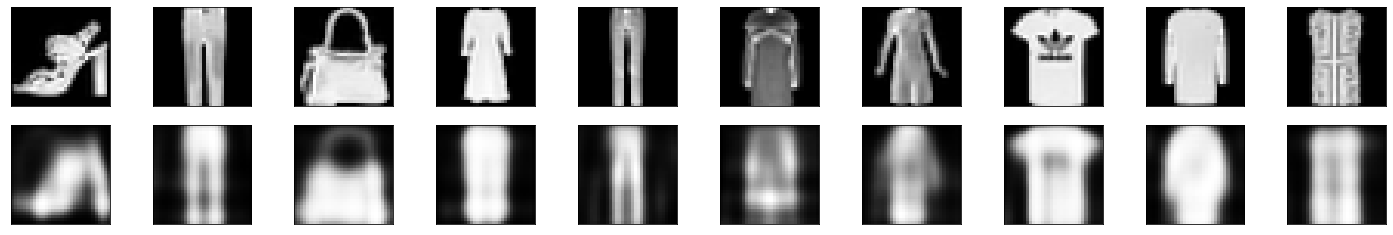

In [17]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)

# get sample outputs
output, _, _, _ = model(images)
# prep images for display
images = images.detach().cpu().numpy()


# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

images = images[:20]
output = output[:20]

print(output.shape, images.shape)

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)